# Mitigating class imbalances using GANs #

In [42]:
import os
from PIL import Image # type: ignore
import numpy as np # type: ignore
from tqdm import tqdm # type: ignore
import albumentations as A # type: ignore
from albumentations.pytorch import ToTensorV2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
from collections import Counter
import torchvision.models as models
import torch
import torch.nn as nn

### Preparing datasets ###

In [43]:
class Dataset:
    def __init__(self, path, transform, classes='all', synthetic_over_sampling=None):
        self.path = path
        self.transform = transform
        self.labels = []
        self.images = []
        if classes == 'all':
            self.classEncoding = {'dog': 0, 'cat': 1, 'horse': 2, 'elephant': 3, 'butterfly': 7, 'chicken': 5, 'cow': 6, 'spider': 4, 'squirrel': 8, 'sheep': 9}
        else:
            self.classEncoding = {}
            for i, c in enumerate(classes):
                self.classEncoding[c] = i
        self.load_data()

        self.syntetic_samples = None
        if synthetic_over_sampling is not None:
            self.synthetic_transform = synthetic_over_sampling
            self.SyntheticOversampling()
    
    def load_data(self):
        for filename in tqdm(os.listdir(self.path)):
            if filename.split('_')[0] not in self.classEncoding:
                continue
            
            self.labels.append(self.classEncoding[filename.split('_')[0]])
            img_name = os.path.join(self.path, filename)
            self.images.append(img_name)

    def __getitem__(self, idx):
        if self.syntetic_samples is not None:
            if self.syntetic_samples[idx] == 1:
                img = Image.open(self.images[idx])
                img = self.synthetic_transform(image=np.array(img))['image']
                label = self.labels[idx]
                return img, label
            else:
                img = Image.open(self.images[idx])
                img = self.transform(image=np.array(img))['image']
                label = self.labels[idx]
                return img, label
        else:
            img = Image.open(self.images[idx])
            img = self.transform(image=np.array(img))['image']
            label = self.labels[idx]
            return img, label
    
    def __len__(self):
        return len(self.images)
    
    def get_classEncoding(self):
        return self.classEncoding
    
    def get_class_balance(self):
        label_counts = Counter(self.labels)
        return label_counts
    
    def RandomOversampling(self):
        '''
        Random Oversampling of minority classes
        '''
        class_balance = self.get_class_balance()
        max_count = max(class_balance.values())
        for label, count in class_balance.items():
            if count == max_count:
                continue
            idx = [i for i, x in enumerate(self.labels) if x == label]
            for i in range(max_count - count):
                self.labels.append(label)
                self.images.append(self.images[np.random.choice(idx)])

    def SyntheticOversampling(self):
        '''
        Synthetic Oversampling of minority classes
        '''
        class_balance = self.get_class_balance()
        max_count = max(class_balance.values())
        self.syntetic_samples = [0 for _ in range(len(self.labels))]

        for label, count in class_balance.items():
            if count == max_count:
                continue
            idx = [i for i, x in enumerate(self.labels) if x == label]
            for i in range(max_count - count):
                img_name = self.images[np.random.choice(idx)]
                self.syntetic_samples.append(1)
                self.images.append(img_name)
                self.labels.append(label)


##### Baseline - Original dataset #####

In [44]:
img_size = 32
transform_baseline = A.Compose([
    A.Resize(img_size, img_size),  # Ensure consistent size
    A.HorizontalFlip(p=0.5),  # Basic flip to prevent overfitting to orientation
    A.Rotate(limit=15, p=0.3),  # Slight rotation to generalize against small angle variations
    A.RandomBrightnessContrast(p=0.2),  # Light contrast and brightness adjustment
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
    ToTensorV2(),  # Convert to tensor
])
samples = ['cat', 'dog', 'horse', 'elephant', 'spider']

bs_train = Dataset('data/Training', transform_baseline, classes=samples)
balance = bs_train.get_class_balance()
enc = bs_train.get_classEncoding()
renc = {v: k for k, v in enc.items()}
for k, v in balance.items():
    print(f'{renc[k]}: {v}')


100%|██████████| 21311/21311 [00:00<00:00, 1578149.55it/s]

dog: 4151
spider: 4114
cat: 1276
elephant: 1076
horse: 2136


##### Random Oversampling #####

In [45]:
transform_oversampling = transform_baseline
ro_train_oversampling = Dataset('data/Training', transform_oversampling, classes=samples)
ro_train_oversampling.RandomOversampling()


100%|██████████| 21311/21311 [00:00<00:00, 1171200.00it/s]


##### Synthetic Oversampling #####

In [46]:
transform_synthetic = A.Compose([
    A.Resize(img_size, img_size),  # Ensure consistent size
    A.HorizontalFlip(p=0.5),  # Increase probability to 50%
    A.VerticalFlip(p=0.5),    # Increase probability to 50%
    A.Rotate(limit=30, p=0.5),  # Increase rotation probability
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Small shifts and scaling
    A.RandomResizedCrop(img_size, img_size, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),  # Crop & resize
    A.RandomBrightnessContrast(p=0.5),  # Already included
    A.HueSaturationValue(p=0.5),  # Add hue and saturation jittering
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Add noise
    A.MotionBlur(blur_limit=3, p=0.2),  # Optional: Add motion blur
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet values
    ToTensorV2(),  # Convert to tensor
])

normal_transform = transform_baseline
so_train = Dataset('data/Training', normal_transform, classes=samples, synthetic_over_sampling=transform_synthetic)

100%|██████████| 21311/21311 [00:00<00:00, 1294006.78it/s]


##### GAN Augmented dataset #####

In [47]:
transform_gan = transform_baseline
gan_train = Dataset('data/GAN_Augmented_Training', transform_gan, classes=samples)

100%|██████████| 29176/29176 [00:00<00:00, 1395168.43it/s]


##### Evaluation sets #####

In [48]:
eval_transform = transform_baseline
val_dataset = Dataset('data/Validation', eval_transform, classes=samples)
test_dataset = Dataset('data/Test', eval_transform, classes=samples)

100%|██████████| 2500/2500 [00:00<00:00, 1054375.06it/s]


##### Showing class balance #####

['butterfly', 'chicken', 'cow', 'squirrel', 'sheep']


100%|██████████| 21311/21311 [00:00<00:00, 1154946.99it/s]


Counter({5: 2563, 7: 1676, 6: 1454, 8: 1451, 9: 1413})
Counter({0: 4151, 4: 4114, 2: 2136, 1: 1276, 3: 1076})


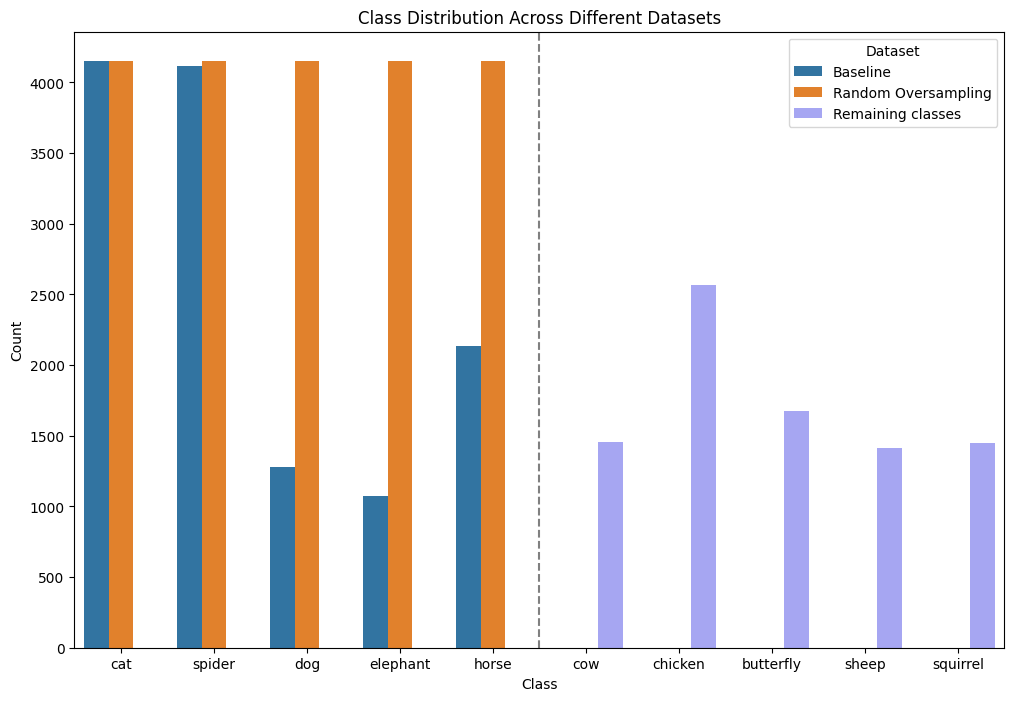

In [51]:
import seaborn as sns
import pandas as pd

# Get class balances
all_classes = ['dog', 'cat', 'horse', 'elephant', 'butterfly', 'chicken', 'cow', 'spider', 'squirrel', 'sheep']
samples = ['dog', 'cat', 'horse', 'elephant', 'spider']
remaining_classes = [c for c in all_classes if c not in samples]
print(remaining_classes)

bs_train = Dataset('data/Training', transform_baseline, classes=samples)
bs_balance = bs_train.get_class_balance()

ro_train_oversampling = Dataset('data/Training', transform_baseline, classes=samples)
ro_train_oversampling.RandomOversampling()
ro_balance = ro_train_oversampling.get_class_balance()

re_data = Dataset('data/Training', transform_baseline, classes='all')
re_labels = re_data.labels
re_balance = Counter(re_labels)
for k in samples:
    re_balance.pop(re_data.classEncoding[k])
print(re_balance)
print(bs_balance)

data = []

# Add baseline balance
for k, v in bs_balance.items():
    data.append({'Dataset': 'Baseline', 'Class': renc[k], 'Count': v})

# Add random oversampling balance
for k, v in ro_balance.items():
    data.append({'Dataset': 'Random Oversampling', 'Class': renc[k], 'Count': v})

# Add remaining classes balance
renc = {v: k for k, v in re_data.classEncoding.items()}
for k, v in re_balance.items():
    data.append({'Dataset': 'Remaining classes', 'Class': renc[k], 'Count': v})
    

df = pd.DataFrame(data)
# Define a custom color palette
palette = {
    'Baseline': '#1f77b4',  # Blue
    'Random Oversampling': '#ff7f0e',  # Orange
    'Remaining classes': '#ff9999'  # Light Red
}
palette['Remaining classes'] = '#9999ff'  # Light Blue

plt.figure(figsize=(12, 8))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df, palette=palette)
plt.axvline(x=4.5, color='gray', linestyle='--')
plt.title('Class Distribution Across Different Datasets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Dataset')
plt.show()

### Classification ###

##### Set up network #####

In [52]:
def LoadModel(name='ResNet', num_classes=10):
    if name=='ResNet':
        model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        #for name, param in model.named_parameters():
            #if "layer4" not in name:
            #    param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # 50% Dropout
            nn.Linear(num_ftrs, num_classes)
            )
        return model
    else:
        path = 'data/models/'
        path = os.path.join(path, name + '.ckpt')
        checkpoint = torch.load(path)
        model = models.resnet50()
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.0),  # 50% Dropout
            nn.Linear(num_ftrs, num_classes)
            )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.fc.load_state_dict(checkpoint['model_classifier'])
        val_acc = checkpoint['val_acc']
        val_loss = checkpoint['val_loss']
        train_acc = checkpoint['train_acc']
        train_loss = checkpoint['train_loss']
        return model, val_acc, val_loss, train_acc, train_loss

    
def SaveModel(model, name, val_acc, val_loss, train_acc, train_loss):
    path = 'data/models/'
    if not os.path.exists(path):
        os.makedirs(path)

    model_name = name + '.ckpt'
    model_path = os.path.join(path, model_name)
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'model_classifier': model.fc.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'train_loss': train_loss,
        }, model_path
    )
    print(f'Model saved at {model_path}')


##### Training Algorithm #####

In [53]:
def training_loop(model, val_acc, val_loss, train_acc, train_loss, train_loader, val_loader, criterion, optimizer, device, model_name, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print(f'  - Batch {i+1}/{len(train_loader)}: Loss: {loss.item():.4f}, Acc: {correct/total:.4f}', end='\r')

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs.float())
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs}: T. Acc: {train_acc[-1]:.4f}, T. Loss: {train_loss[-1]:.4f}, V. Acc: {val_acc[-1]:.4f}, V. Loss: {val_loss[-1]:.4f}')
        if val_acc[-1] == max(val_acc):
            SaveModel(model=model, name=model_name,val_acc=val_acc, val_loss=val_loss, train_acc=train_acc, train_loss=train_loss)

    return model, val_acc, val_loss, train_acc, train_loss

def TestModel(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    #print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    return test_acc, test_loss

In [54]:
from torch.utils.data import DataLoader
batch_size = 256

train_loader_baseline = DataLoader(bs_train, batch_size=batch_size, shuffle=True)
train_loader_oversampling = DataLoader(ro_train_oversampling, batch_size=batch_size, shuffle=True)
train_loader_synthetic = DataLoader(so_train, batch_size=batch_size, shuffle=True)
train_loader_gan = DataLoader(gan_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4

##### Baseline - No balancing #####

In [12]:
model_name = 'baseline32'
print(f'Training on device: {device}')

model = LoadModel('ResNet', num_classes=5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, val_acc, val_loss, train_acc, train_loss = training_loop(model, val_acc, val_loss, train_acc, train_loss, train_loader_baseline, val_loader, criterion, optimizer, device, model_name, num_epochs=10)

Training on device: mps
Epoch 1/10: T. Acc: 0.3160, T. Loss: 1.5274, V. Acc: 0.5307, V. Loss: 1.2785
Model saved at data/models/baseline32.ckpt
Epoch 2/10: T. Acc: 0.5707, T. Loss: 1.1411, V. Acc: 0.6443, V. Loss: 0.9886
Model saved at data/models/baseline32.ckpt
Epoch 3/10: T. Acc: 0.6707, T. Loss: 0.8894, V. Acc: 0.7043, V. Loss: 0.8260
Model saved at data/models/baseline32.ckpt
Epoch 4/10: T. Acc: 0.7288, T. Loss: 0.7361, V. Acc: 0.7424, V. Loss: 0.7121
Model saved at data/models/baseline32.ckpt
Epoch 5/10: T. Acc: 0.7772, T. Loss: 0.6058, V. Acc: 0.7728, V. Loss: 0.6377
Model saved at data/models/baseline32.ckpt
Epoch 6/10: T. Acc: 0.8131, T. Loss: 0.5167, V. Acc: 0.7996, V. Loss: 0.5961
Model saved at data/models/baseline32.ckpt
Epoch 7/10: T. Acc: 0.8426, T. Loss: 0.4415, V. Acc: 0.8073, V. Loss: 0.5843
Model saved at data/models/baseline32.ckpt
Epoch 8/10: T. Acc: 0.8582, T. Loss: 0.3914, V. Acc: 0.8186, V. Loss: 0.5488
Model saved at data/models/baseline32.ckpt
Epoch 9/10: T. A

##### Random Oversampling #####

In [13]:
model_name = 'random_oversampling'
print(f'Training on device: {device}')

model = LoadModel('ResNet', num_classes=5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, val_acc, val_loss, train_acc, train_loss = training_loop(model, val_acc, val_loss, train_acc, train_loss, train_loader_oversampling, val_loader, criterion, optimizer, device, model_name, num_epochs=10)

Training on device: mps
Epoch 1/10: T. Acc: 0.3324, T. Loss: 1.5090, V. Acc: 0.5293, V. Loss: 1.2357
Model saved at data/models/random_oversampling.ckpt
Epoch 2/10: T. Acc: 0.6166, T. Loss: 1.0231, V. Acc: 0.6747, V. Loss: 0.8346
Model saved at data/models/random_oversampling.ckpt
Epoch 3/10: T. Acc: 0.7510, T. Loss: 0.6866, V. Acc: 0.7318, V. Loss: 0.7154
Model saved at data/models/random_oversampling.ckpt
Epoch 4/10: T. Acc: 0.8150, T. Loss: 0.5164, V. Acc: 0.7791, V. Loss: 0.6549
Model saved at data/models/random_oversampling.ckpt
Epoch 5/10: T. Acc: 0.8605, T. Loss: 0.3991, V. Acc: 0.7819, V. Loss: 0.6181
Model saved at data/models/random_oversampling.ckpt
Epoch 6/10: T. Acc: 0.8892, T. Loss: 0.3184, V. Acc: 0.7975, V. Loss: 0.6058
Model saved at data/models/random_oversampling.ckpt
Epoch 7/10: T. Acc: 0.9135, T. Loss: 0.2669, V. Acc: 0.8193, V. Loss: 0.5876
Model saved at data/models/random_oversampling.ckpt
Epoch 8/10: T. Acc: 0.9239, T. Loss: 0.2275, V. Acc: 0.8215, V. Loss: 0.5

##### Synthetic Oversampling #####

In [14]:
model_name = 'synthetic_oversampling'
print(f'Training on device: {device}')

model = LoadModel('ResNet', num_classes=5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, val_acc, val_loss, train_acc, train_loss = training_loop(model, val_acc, val_loss, train_acc, train_loss, train_loader_synthetic, val_loader, criterion, optimizer, device, model_name, num_epochs=10)

Training on device: mps
Epoch 1/10: T. Acc: 0.3001, T. Loss: 1.5445, V. Acc: 0.5406, V. Loss: 1.2227
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 2/10: T. Acc: 0.5249, T. Loss: 1.1964, V. Acc: 0.6535, V. Loss: 0.9056
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 3/10: T. Acc: 0.6609, T. Loss: 0.8991, V. Acc: 0.7403, V. Loss: 0.7225
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 4/10: T. Acc: 0.7237, T. Loss: 0.7264, V. Acc: 0.7495, V. Loss: 0.6787
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 5/10: T. Acc: 0.7634, T. Loss: 0.6326, V. Acc: 0.7735, V. Loss: 0.6473
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 6/10: T. Acc: 0.7991, T. Loss: 0.5449, V. Acc: 0.7975, V. Loss: 0.5928
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 7/10: T. Acc: 0.8236, T. Loss: 0.4810, V. Acc: 0.8038, V. Loss: 0.5819
Model saved at data/models/synthetic_oversampling.ckpt
Epoch 8/10: T. Acc: 0.8417, T. Loss: 0.4348, V. Acc:

##### GAN Augmented dataset #####

In [15]:
model_name = 'GAN_augmented'
print(f'Training on device: {device}')

model = LoadModel('ResNet', num_classes=5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

val_acc = []
val_loss = []
train_acc = []
train_loss = []

model, val_acc, val_loss, train_acc, train_loss = training_loop(model, val_acc, val_loss, train_acc, train_loss, train_loader_gan, val_loader, criterion, optimizer, device, model_name, num_epochs=10)

Training on device: mps
Epoch 1/10: T. Acc: 0.3970, T. Loss: 1.4108, V. Acc: 0.5505, V. Loss: 1.2134
Model saved at data/models/GAN_augmented.ckpt
Epoch 2/10: T. Acc: 0.7118, T. Loss: 0.7899, V. Acc: 0.7078, V. Loss: 0.8337
Model saved at data/models/GAN_augmented.ckpt
Epoch 3/10: T. Acc: 0.8085, T. Loss: 0.5387, V. Acc: 0.7551, V. Loss: 0.6641
Model saved at data/models/GAN_augmented.ckpt
Epoch 4/10: T. Acc: 0.8487, T. Loss: 0.4193, V. Acc: 0.7833, V. Loss: 0.6071
Model saved at data/models/GAN_augmented.ckpt
Epoch 5/10: T. Acc: 0.8796, T. Loss: 0.3383, V. Acc: 0.8059, V. Loss: 0.5671
Model saved at data/models/GAN_augmented.ckpt
Epoch 6/10: T. Acc: 0.8968, T. Loss: 0.2920, V. Acc: 0.8186, V. Loss: 0.5177
Model saved at data/models/GAN_augmented.ckpt
Epoch 7/10: T. Acc: 0.9151, T. Loss: 0.2445, V. Acc: 0.8278, V. Loss: 0.5253
Model saved at data/models/GAN_augmented.ckpt
Epoch 8/10: T. Acc: 0.9254, T. Loss: 0.2102, V. Acc: 0.8271, V. Loss: 0.5410
Epoch 9/10: T. Acc: 0.9390, T. Loss: 0

### Performance Evaluation ###

Baseline: Cohen Kappa: 0.6490, Accuracy: 0.7192, Loss: 0.8287
Random Oversampling: Cohen Kappa: 0.7040, Accuracy: 0.7632, Loss: 0.8056
Synthetic Oversampling: Cohen Kappa: 0.7100, Accuracy: 0.7680, Loss: 0.6979
GAN Augmented: Cohen Kappa: 0.6950, Accuracy: 0.7560, Loss: 0.7873


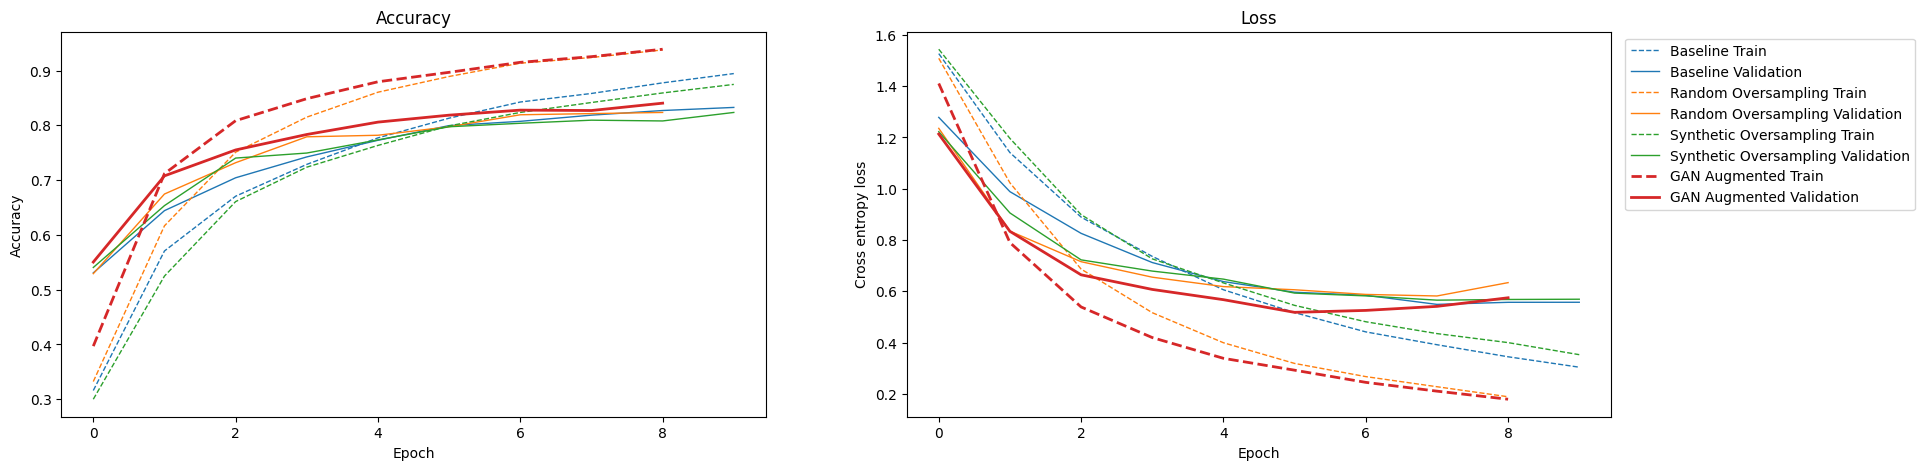

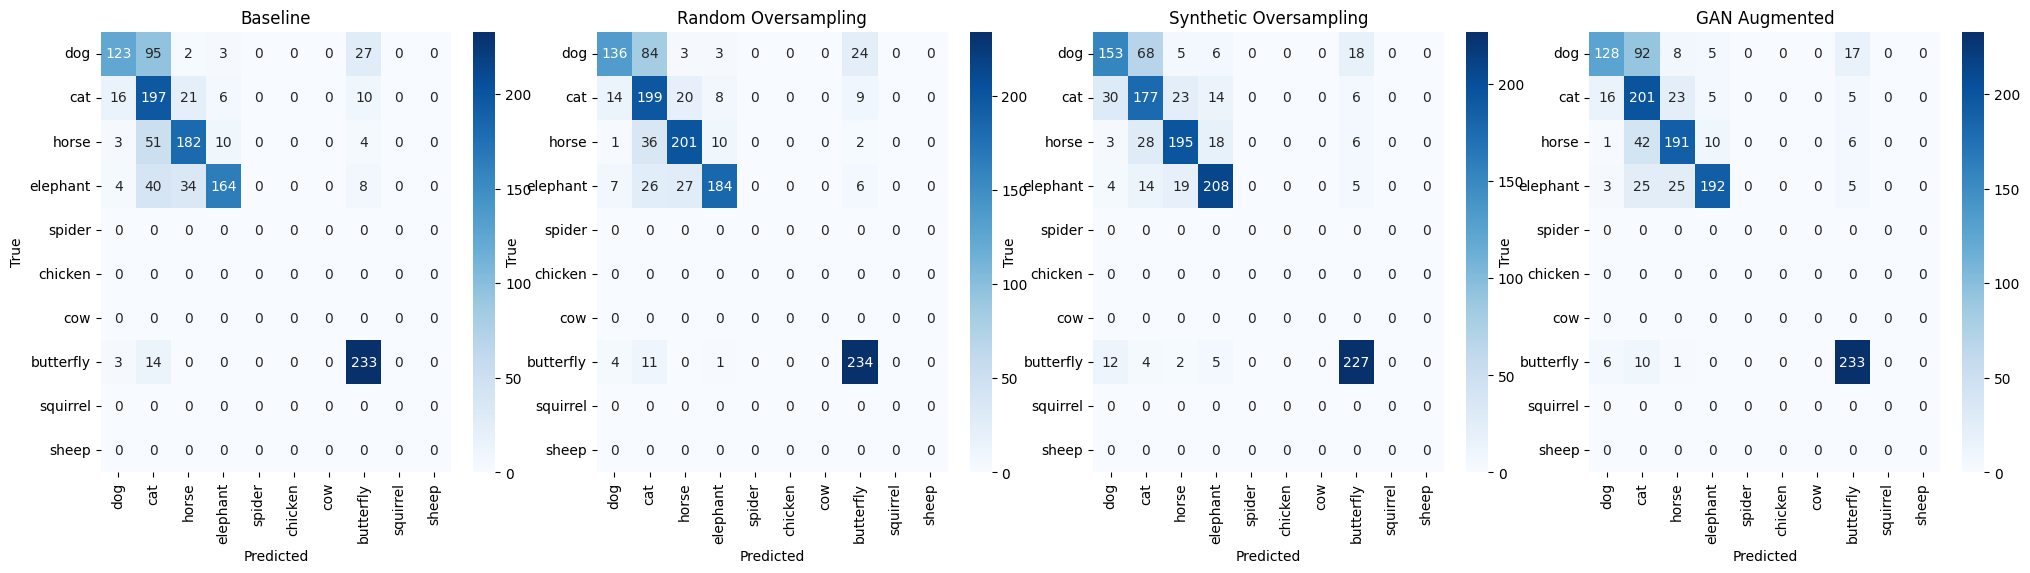

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, classification_report

model_names = ['baseline32', 'random_oversampling', 'synthetic_oversampling', 'GAN_augmented']
headers = {'baseline32': 'Baseline', 'random_oversampling': 'Random Oversampling', 'synthetic_oversampling': 'Synthetic Oversampling', 'GAN_augmented': 'GAN Augmented'}
colors = ['#E69F00', '#56B4E9', '#D55E00', '#CC79A7']  # Orange, Light Blue, Red-Orange, Pink
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
fig, ax = plt.subplots(1, 2, figsize=(5*len(model_names), 5))
fig2, ax2 = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
fig2.tight_layout()
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Cross entropy loss')
test_performance = {}
for i, name in enumerate(model_names):
    model, val_acc, val_loss, train_acc, train_loss = LoadModel(name, num_classes=5)
    if name == 'GAN_augmented':
        lw = 2
    else:
        lw = 1

    ax[0].plot(train_acc, label=f'{headers[name]} Train', linestyle='--', color=colors[i], linewidth=lw)
    ax[0].plot(val_acc, label=f'{headers[name]} Validation', color=colors[i], linewidth=lw)
    ax[1].plot(train_loss, label=f'{headers[name]} Train', linestyle='--', color=colors[i], linewidth=lw)
    ax[1].plot(val_loss, label=f'{headers[name]} Validation', color=colors[i], linewidth=lw)
    model.to(device)
    test_acc, test_loss = TestModel(model, test_loader, criterion, device)
    test_performance[name] = (test_acc, test_loss)
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_labels = [renc[i] for i in range(len(renc))]
    cm = confusion_matrix(all_labels, all_preds, labels=list(renc.keys()))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax2[i])
    ax2[i].set_title(f'{headers[name]}')
    ax2[i].set_xlabel('Predicted')
    ax2[i].set_ylabel('True')

    if i == 0:
        cm1 = cm
    elif i == 3:
        cm2 = cm

    ck = cohen_kappa_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)
    print(f'{headers[name]}: Cohen Kappa: {ck:.4f}, Accuracy: {acc:.4f}, Loss: {test_loss:.4f}')
    

#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()


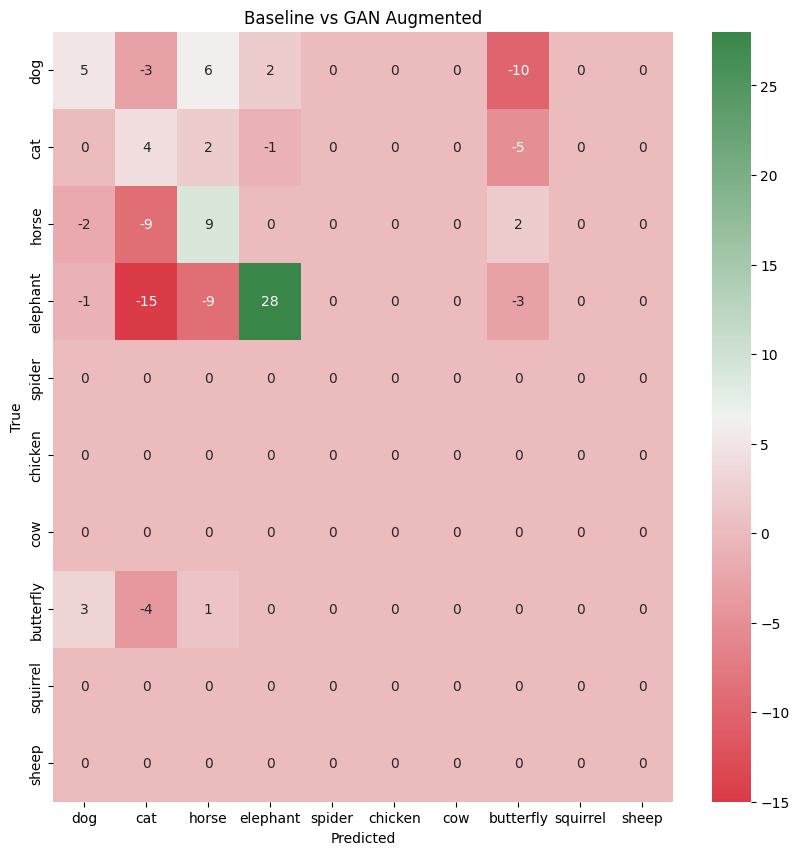

In [57]:
cm = cm2 - cm1
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Baseline vs GAN Augmented')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()